# ResNet

```{note}
ResNet的残差块加了一个恒等映射通路，使得我们能够训练更深的网络<br/>
ResNet是2015年ImageNet比赛的冠军
```

## 结构

下图比较了一个正常块和一个残差块，残差块加了一个恒等映射通路，在最后的激活函数前相加：

![jupyter](../images/d/residual-block.svg)

残差块使得随着网络的加深，函数空间总是嵌套的！而且它能缓解反向传播时的梯度消失和梯度爆炸，最终让ResNet又快又好：

![jupyter](../images/d/functionclasses.svg)

在GoogleNet节中我们知道，$1\times{1}$ 卷积可以调整通道数和分辨率，它的功能类似于恒等映射，因此我们可以做出两类残差块：

![jupyter](../images/d/resnet-block.svg)

In [9]:
import torch
from torch import nn
import torch.nn.functional as F


class Residual(nn.Module):
    """ResNet的残差块"""
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        # use_1x1conv=False时，必须input_channels=num_channels & strides=1
        # 不然相加时shap不一致
        super().__init__()
        # 第一个卷积层完成通道和分辨率转换
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        # 使用1*1卷积完成通道和分辨率转换
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        # BatchNorm在卷积层和激活函数之间
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        # 正常块
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        # 1*1 conv layer instead of identity sometimes
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

## 实现

下面实现我们简易版的ResNet。

In [2]:
# 开头为普通卷积层
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [3]:
# 第一个残差模块
b2 = nn.Sequential(Residual(64, 64), 
                   Residual(64, 128, use_1x1conv=True, strides=2),
                   Residual(128, 128))

In [4]:
# 第二个残差模块
b3 = nn.Sequential(Residual(128, 256, use_1x1conv=True, strides=2),
                   Residual(256, 256))

In [5]:
# ResNet18
net = nn.Sequential(b1, b2, b3, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(256, 10))

In [6]:
X = torch.rand(size=(1, 1, 28, 28))
# 打印各部分的shape
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 14, 14])
Sequential output shape:	 torch.Size([1, 128, 7, 7])
Sequential output shape:	 torch.Size([1, 256, 4, 4])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 256, 1, 1])
Flatten output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 10])


## 训练

In [7]:
import d2l

# 载入数据
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

loss 0.141, train acc 0.947367, test acc  0.911000


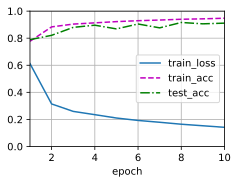

In [8]:
# 训练
lr, num_epochs = 0.01, 10
d2l.train_image_classifier(net, train_iter, test_iter, lr, num_epochs)